In [1]:
import pandas as pd
import numpy as np

In [23]:
file_path="data/경제활동인구근로형태별DB_09-04_21-47.csv"
df=pd.read_csv(file_path, encoding="cp949")

In [24]:
#데이터 전처리
df=df.drop(columns='Unnamed: 0', axis=1)

In [25]:
#근속 구하기 
enterance_date_col_name='현재일관련사항_직장시작연월'
census_date_col_name='조사연월'
enterance_date_col=[]
census_date_col=[]
len_of_service=[]
enterance_date_col = pd.to_datetime(df[enterance_date_col_name].astype(str), format='%Y%m')
census_date_col = pd.to_datetime(df[census_date_col_name].astype(str), format="%Y%m")

len_of_service=(census_date_col.dt.year - enterance_date_col.dt.year)*12 +(census_date_col.dt.month - enterance_date_col.dt.month)
df_len_of_service = pd.Series(len_of_service, name="재직기간")

len_of_service

df_len_of_service

df=pd.concat([df, df_len_of_service], axis=1)
df=df.drop(columns=[enterance_date_col_name,census_date_col_name])
print (f"{enterance_date_col_name}과 {census_date_col_name}을 이용해 [재직월수] 칼럼을 만들었습니다.")

현재일관련사항_직장시작연월과 조사연월을 이용해 [재직월수] 칼럼을 만들었습니다.


In [26]:
#가중값 분리
df_w= df['가중값']
df=df.drop(columns='가중값', axis=1)


In [27]:
#연속 값의 구간 범주화
all_col=df.columns.tolist()
col_cont=[col for col in all_col if not any(keyword in col for keyword in ['코드','여부'] )]

q_wage= 5 #임금총액의 분위수 
q_features=10 #나머지 범주들의 분류 갯수
boundary_list={}

for col in col_cont:
    if "급여" in col:
        col_name_decile= f"{col}_{q_wage}분위"
        df[col_name_decile], bin_edges = pd.qcut(df[col], q=q_wage, duplicates='drop',labels=range(0,q_wage), retbins=True)
    else:
        col_name_decile= f"{col}_{q_features}분위"
        df[col_name_decile], bin_edges = pd.qcut(df[col], q=q_features, duplicates='drop',labels=False, retbins=True)
    boundary_list[col]=bin_edges.tolist()
    df[col_name_decile]=df[col_name_decile].astype(int)
df_cont=df[col_cont] #연속값 칼럼 따로 저장
df=df.drop(col_cont, axis=1)

In [ ]:
#XGBoost 전처리
target_col= [col for col in df.columns.tolist() if '평균급여' in col]
df_y= df[target_col]
df=df.drop(columns=target_col, axis=1)
df_x=df
from sklearn.model_selection import train_test_split
x_t, x_10, y_t, y_10, w_t, w_10 = train_test_split(df_x,df_y,df_w, test_size=0.1, random_state=36)

del df

In [35]:
#XGBoost

import xgboost as xgb

model= xgb.XGBClassifier(
    objective='multi:softmax', 
    num_class=q_wage, 
    eval_metric='mlogloss', 
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=8,
    verbosity=0)

model.fit(x_t, y_t, sample_weight=w_t)
y_pred = model.predict(x_10)

In [94]:
#학습된 모델 저장
import joblib
joblib.dump(model, 'xgboost_model_경제활동부가조사.pkl')

['xgboost_model_경제활동부가조사.pkl']

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(y_10, y_pred, sample_weight=w_10)
print(f"\n정확도: {accuracy:.4f}")
print("\n### 혼동 행렬 ###")
print(confusion_matrix(y_10, y_pred))

print("\n### 분류 리포트 ###")
print(classification_report(y_10, y_pred))


정확도: 0.6259

### 혼동 행렬 ###
[[2151  359   17   17    5]
 [ 262 1858  455  210   46]
 [  41  653  865  579   98]
 [  19  285  403 1393  529]
 [   9   54   82  498 1880]]

### 분류 리포트 ###
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      2549
           1       0.58      0.66      0.62      2831
           2       0.47      0.39      0.43      2236
           3       0.52      0.53      0.52      2629
           4       0.73      0.75      0.74      2523

    accuracy                           0.64     12768
   macro avg       0.63      0.63      0.63     12768
weighted avg       0.64      0.64      0.64     12768



In [38]:
#변수 영향력 분석_ 샤프 분석
import shap
x_shap = x_10.sample(n=1000, random_state=12)
explainer =shap.TreeExplainer(model)
shap_value = explainer(x_shap)


In [ ]:
# 샤프 값 후처리
shap_mean_value=np.empty((q_wage,f_num)) #1000개 샘플 샤프 값의 평균을 배열로 정리
for i in range(q_wage): # [임금분위, 칼럼] 배열로 샤프 값 저장
    for j in range(f_num):
        shap_mean_value[i][j] = np.abs(shap_value.values[:,j,i]).mean()

shap_by_feature= shap_mean_value.mean(axis=0) #임금분위 전체의 평균 샤프값

#샤프 값 DataFrame
shap_by_feature_df=pd.DataFrame(shap_by_feature, index=shap_value.feature_names) 

shap_by_feature_df.columns=['평균샤프값']

for i in range(q_wage):
    col_name=f"임금{i+1}분위"
    shap_by_feature_df[col_name] =shap_mean_value[i]
shap_by_feature_df

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

In [118]:
shap_by_feature_df

,평균샤프값,임금1분위,임금2분위,임금3분위,임금4분위,임금5분위
가구주관계코드,0.115533,0.155249,0.121549,0.060253,0.095784,0.144828
성별코드,0.305818,0.371222,0.316291,0.096510,0.285755,0.459313
교육정도_학력구분코드,0.075906,0.091257,0.083548,0.059394,0.061288,0.084041
교육정도_계열코드,0.100566,0.130469,0.094406,0.070062,0.069123,0.138768
교육정도_수학구분코드,0.017042,0.026267,0.017063,0.017079,0.010792,0.014011
혼인상태코드,0.069182,0.063846,0.069398,0.043854,0.033452,0.135359
현재일관련사항_지난주수입목적근로여부,0.005934,0.003391,0.004995,0.009840,0.004017,0.007428
현재일관련사항_지난주부업여부,0.018039,0.034261,0.016280,0.005421,0.009611,0.024619
현재일관련사항_지난주총근로시간구분코드,0.022894,0.055388,0.010266,0.017416,0.017684,0.013715
현재일관련사항_10차산업대분류코드,0.245148,0.274951,0.151380,0.131510,0.226305,0.441593


In [ ]:
#인덱스 이름 수정.

new_index=[]
del_words=['현재일관련사항_', '코드', '여부', '_10분위','_5분위']
for col in shap_by_feature_df.index :
    a=col
    for key in del_words:
        a=a.replace(key, '')
    new_index.append(a)

new_index2=[(name.split('_')[1] if '_' in name else name) for name in new_index ]
new_index3=[name.replace('전일제근로', '주간근로시간(전일제)') for name in new_index2] 

shap_by_feature_df.index = new_index3 #1,2,3 중에 선택.

In [245]:
shap_by_feature_df.index = new_index3 

<Axes: title={'center': '임금에 미치는 항목의 영향도(임금분위별)'}>

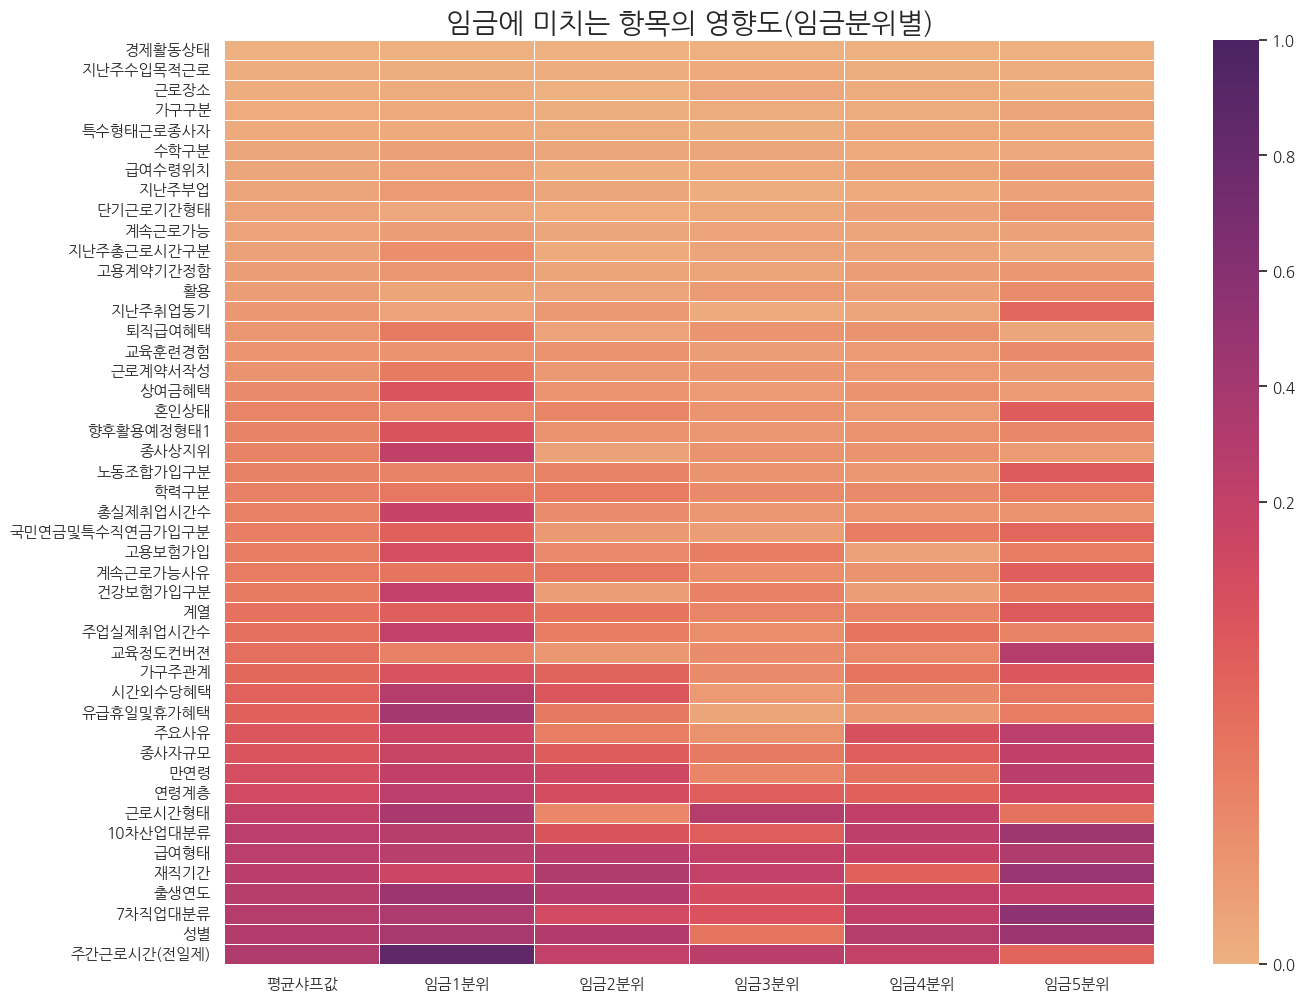

In [246]:
#변수 전체 상황을 보여주는 히트맵
import matplotlib.colors as mcolors
plt.rc('font', family='NanumGothic')
colors = ['#cccc99', '#cccc66', '#993333']
boundaries = [0, 0.1, 0.2, 1.0]
cmap1 = mcolors.ListedColormap(colors)
norm1 = mcolors.BoundaryNorm(boundaries, cmap.N)
f, ax = plt.subplots(figsize=(15, 12))
shap_by_feature_df=shap_by_feature_df.sort_values(by='평균샤프값')
norm2 = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.2, vmax=1.0)
cmap2 ='flare'
plt.title('임금에 미치는 항목의 영향도(임금분위별)',fontsize=20)
sns.heatmap(shap_by_feature_df, cmap=cmap2, norm=norm2, linewidths=0.5) #연속값 스타일은 2번, 상중하 스타일은 1번.

In [247]:
# 범프 차트를 위한 전처리
top10=shap_by_feature_df.sort_values(by='평균샤프값', ascending=False).head(10)
top10_order=top10.rank(axis=0, ascending=False, method='first')
top10_order=top10_order.drop(columns=['평균샤프값','임금2분위','임금3분위','임금4분위'], axis=1)

In [248]:
top10_order_long=top10_order.unstack().reset_index()
top10_order_long=top10_order_long.rename(columns={'level_0':'임금분위', 'level_1':'항목', 0:'영향력'})

In [249]:
#범프차트 그리기
import plotly.express as px

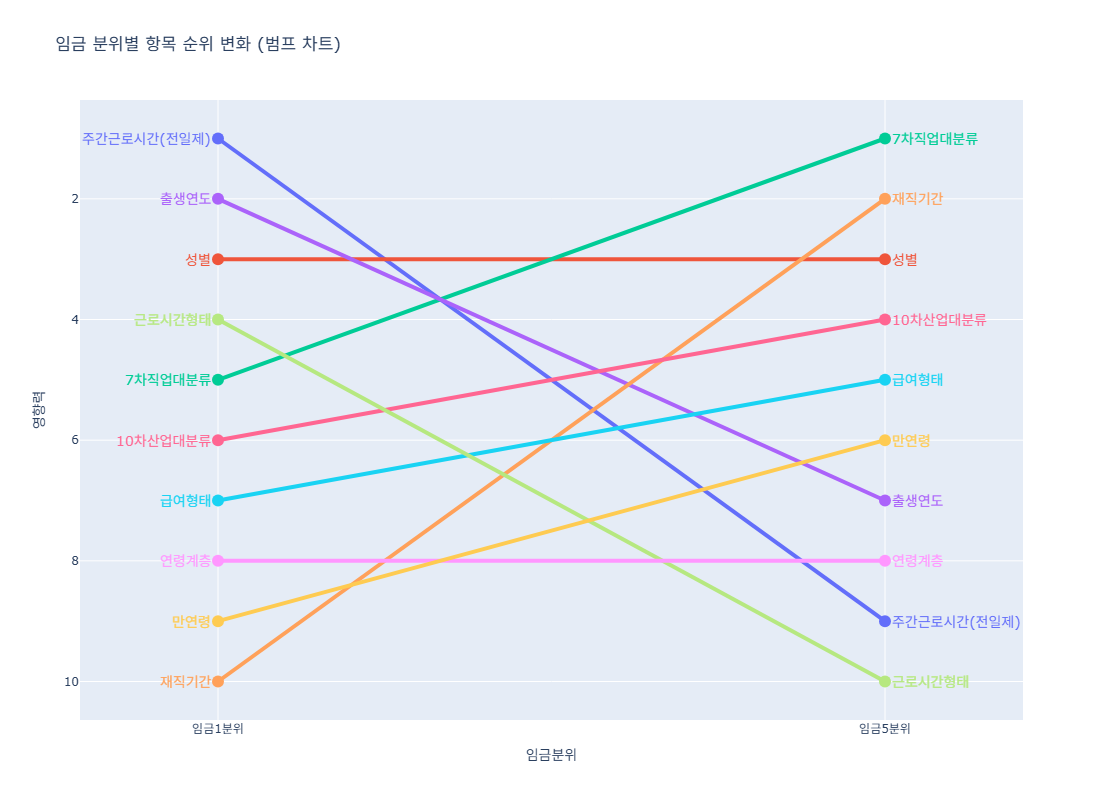

In [252]:
top10_order_long['임금분위'] = pd.Categorical(top10_order_long['임금분위'],
                                            categories=['임금1분위', '임금5분위'],
                                            ordered=True)

# Plotly Express로 범프 차트 생성
fig = px.line(
    top10_order_long,
    x='임금분위',
    y='영향력',
    color='항목',       # 각 항목에 따라 다른 색상
    text='항목',       # 각 점에 항목 텍스트 표시
    line_shape='spline', # 핵심: 곡선으로 연결
    markers=True,        # 점(마커) 표시
    title='임금 분위별 항목 순위 변화 (범프 차트)',
    hover_name='항목',  # 마우스 오버 시 항목 이름 표시
    width=600,
    height=800

)

# y축을 뒤집어서 1위가 위에 오도록 설정
fig.update_yaxes(autorange="reversed")

# 라인 굵기 및 마커 크기 조절
fig.update_traces(
    line=dict(width=4),
    marker=dict(size=12),
)

# 텍스트 레이블 커스터마이징 (선 끝에만 표시)
fig.for_each_trace(lambda trace: trace.update(textfont_color='rgba(0,0,0,0)')) # 모든 텍스트 투명하게

# 각 항목에 대해 첫 점과 끝 점에만 라벨(annotation) 추가
for i, item_name in enumerate(top10_order_long['항목'].unique()):
    # 마지막 점 데이터 찾기
    last_point = top10_order_long[(top10_order_long['항목'] == item_name) &
                                (top10_order_long['임금분위'] == top10_order_long['임금분위'].cat.categories[-1])]
    if not last_point.empty:
        fig.add_annotation(
            x=last_point['임금분위'].iloc[0],
            y=last_point['영향력'].iloc[0],
            text=f" {item_name}",
            showarrow=False,
            xanchor='left',
            font=dict(size=14, color=fig.data[i].line.color),
            yanchor='middle'
        )
    # 첫번째 점 데이터 찾기
    first_point = top10_order_long[(top10_order_long['항목'] == item_name) &
                                 (top10_order_long['임금분위'] == top10_order_long['임금분위'].cat.categories[0])]
    if not first_point.empty:
        fig.add_annotation(
            x=first_point['임금분위'].iloc[0],
            y=first_point['영향력'].iloc[0],
            text=f"{item_name} ",
            showarrow=False,
            xanchor='right',
            font=dict(size=14, color=fig.data[i].line.color),
            yanchor='middle'
        )

# 범례 숨기기
fig.update_layout(showlegend=False)

fig.show()